In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from sklearn.metrics import confusion_matrix, accuracy_score
import skopt
import scipy
from skopt.space import Real
import category_encoders
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
import math

PREDICCION_REAL = False
MAXIMIZAR_HIPERPARAMETROS = False
PARAMETROS = {
    
}



In [2]:
#APERTURA DE ARCHIVO DE ARCHIVOS
entrenamiento = pd.read_pickle("../Archivos/Arboles_entrenamiento_exp.pkl").drop(columns = ["Opportunity_ID"])
test = pd.read_pickle("../Archivos/Arboles_validacion_exp.pkl").drop(columns = ["Opportunity_ID"])
test_real = pd.read_pickle("../Archivos/Arboles_validacion_exp.pkl")
if PREDICCION_REAL:
    test = pd.read_pickle("../Archivos/Arboles_test_exp.pkl").drop(columns = ["Opportunity_ID"])
    test_real = pd.read_pickle("../Archivos/Arboles_test_exp.pkl")

In [3]:
entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12140 entries, 0 to 12139
Columns: 134 entries, Region to Last_Modified_By_Total_Amount_Currency_unique
dtypes: category(18), datetime64[ns](7), float64(82), int64(27)
memory usage: 11.1 MB


In [4]:
#FILTRADO DE COLUMNAS - NO REMOVER STAGE O FECHA
#fugas = ['ID','Opportunity_Name','Sales_Contract_No','Account_Name','Account_Owner','Opportunity_Owner','Last_Modified_By','Product_Family','Product_Name','ASP','ASP_(converted)']
#'Total_Taxable_Amount'
#columnas_fecha = ['Month','Last_Modified_Date','Account_Created_Date','Opportunity_Created_Date','Quote_Expiry_Date','Planned_Delivery_Start_Date','Planned_Delivery_End_Date']
#entrenamiento = entrenamiento.drop(columns=fugas)
#test = test.drop(columns=fugas)
#test = test.drop(columns=columnas_fecha)
#entrenamiento = entrenamiento.drop(columns=columnas_fecha)

In [5]:
#FECHAS A DIAS

columnas_fecha = ['Last_Modified_Date','Account_Created_Date','Opportunity_Created_Date','Quote_Expiry_Date','Planned_Delivery_Start_Date','Planned_Delivery_End_Date',"Year-Month"]
def fecha_a_dias(x):
    for columna in columnas_fecha:
        x[columna] = x[columna].apply(lambda x : (x - pd.to_datetime('01/01/2000', format='%m/%d/%Y')).days)

fecha_a_dias(entrenamiento)
fecha_a_dias(test)

In [6]:
objetivo = (entrenamiento['Stage'] == 1).astype(int)
entrenamiento = entrenamiento.drop(columns=['Stage'])
columnas_category = list(entrenamiento.select_dtypes(include=['category']).columns)
if 'Stage' in columnas_category : columnas_category.remove('Stage')

In [7]:
if not PREDICCION_REAL:
    test_label = (test['Stage'] == 1).astype(int)
    test = test.drop(columns=['Stage'])

In [8]:
def categoricas_a_numericas(train,test,label,usar_label):
    if (usar_label):
        columnas_object = list(train.select_dtypes(include=['category']).columns)
    else:
        columnas_object = list(test.select_dtypes(include=['category']).columns)
    if 'Stage' in columnas_object : columnas_object.remove('Stage')
    ohe = category_encoders.cat_boost.CatBoostEncoder(cols = columnas_object,return_df = True)
    ohe.fit(train,label)
    if (usar_label):
        columnas = ohe.transform(train,label)
        for columna in columnas_object:
            train[columna] = columnas[columna].copy()
    else:
        columnas = ohe.transform(test)
        for columna in columnas_object:
            test[columna] = columnas[columna].copy()
categoricas_a_numericas(entrenamiento,test,objetivo,False)
categoricas_a_numericas(entrenamiento,test,objetivo,True)

C:\Users\gianb\anaconda3\envs\TP2-Orga\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\gianb\anaconda3\envs\TP2-Orga\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [9]:
def limpiar_nan(col):
    mean = entrenamiento[col].mean()
    entrenamiento[col] = entrenamiento[col].replace(np.NaN,mean)
    mean = test[col].mean()
    test[col] = test[col].replace(np.NaN,mean)

In [10]:
def limpiar_inf(col):
    entrenamiento[col] = entrenamiento[col].replace(math.inf,np.NaN)
    test[col] = test[col].replace(math.inf,np.NaN)

In [11]:
#entrenamiento = entrenamiento.drop(columns = ["Quote_Expiry_Date","Total_Products_Region_Quarter_Change"])
#test = test.drop(columns = ["Quote_Expiry_Date","Total_Products_Region_Quarter_Change"])

In [12]:
for col in entrenamiento.columns:
    ent_null = entrenamiento.loc[entrenamiento[col] == np.inf]
    if (ent_null[col].count() > 1000):
        print(col)
        print(ent_null[col].count())
        entrenamiento = entrenamiento.drop(columns = [col])
        test = test.drop(columns = [col])
    if (0<ent_null[col].count() <= 1000):
        print(col)
        print(ent_null[col].count())
        limpiar_inf(col)        
for col in test.columns:
    ent_null = test.loc[test[col] == np.inf]
    if (ent_null[col].count() > 1000):
        print(col)
        print(ent_null[col].count())
        entrenamiento = entrenamiento.drop(columns = [col])
        test = test.drop(columns = [col])
    if (0<ent_null[col].count() <= 1000):
        print(col)
        print(ent_null[col].count())
        limpiar_inf(col)        

In [13]:
for col in entrenamiento.columns:
    ent_null = entrenamiento.loc[entrenamiento[col].isnull()]
    ent_null = ent_null.replace(np.NaN,0)
    if (ent_null[col].count() > 1000):
        print(col)
        print(ent_null[col].count())
        entrenamiento = entrenamiento.drop(columns = [col])
        test = test.drop(columns = [col])
    if (0<ent_null[col].count() <= 1000):
        print(col)
        print(ent_null[col].count())
        limpiar_nan(col)        
for col in test.columns:
    ent_null = test.loc[test[col].isnull()]
    ent_null = ent_null.replace(np.NaN,0)
    if (ent_null[col].count() > 1000):
        print(col)
        print(ent_null[col].count())
        entrenamiento = entrenamiento.drop(columns = [col])
        test = test.drop(columns = [col])
    if (0<ent_null[col].count() <= 1000):
        print(col)
        print(ent_null[col].count())
        limpiar_nan(col)        

Total_Amount(USD)
24
Total_Taxable_Amount(USD)
4
Opportunity_Taxable_Rate
47
Product_Amount_Deviation_of_Product_Family_rate
25
ASP_by_Billing_Country_std
14
Total_Amount_by_Billing_Country_std
14
Buro_Approved_by_Billing_Country_std
14
Opportunity_Duration_by_Product_Family_std
31
Total_Amount_by_Product_Family_std
31
Buro_Approved_by_Product_Family
31
Family_Duration
59
Territory_Duration
77
Bureaucratic_Code_ASP_(converted)_std
1
Bureaucratic_Code_Total_Product_Family_Region_Last_Month_std
1
Bureaucratic_Code_Total_Products_Region_Last_Week_std
1
Bureaucratic_Code_Planned_Deliver_Duration_std
1
Bureaucratic_Code_Actual_Opportunity_Duration_std
1
Bureaucratic_Code_Planned_Time_Until_Deliver_std
1
Bureaucratic_Code_Product_Amount_Deviation_of_Product_Family_rate_std
1
Bureaucratic_Code_Opportunity_Duration_Ratio_std
1
Bureaucratic_Code_Opportunity_Total_Amount_Region_avg_std
1
Bureaucratic_Code_Opportunity_TRF_Region_std_Ratio_std
1
Bureaucratic_Code_Opportunity_Duration_by_Account_Ty

In [14]:
a_usar = ['Bureaucratic_Code',
 'Account_Name',
 'Opportunity_Name',
 'Opportunity_Owner',
 'Last_Modified_By',
 'Product_Family',
 'Product_Name',
 'Opportunity_Name_Planned_Time_Until_Deliver_mean',
 'Opportunity_Name_Planned_Opportunity_Duration_mean',
 'Product_Name_Planned_Time_Until_Deliver_mean',
 'Product_Name_Planned_Opportunity_Duration_mean',
 'Territory',
 'Account_Owner',
 'Account_Type',
 'Opportunity_Type',
 'Planned_Opportunity_Duration',
 'Bureaucratic_Code_ASP_(converted)_std',
 'Bureaucratic_Code_Total_Amount_mean',
 'Bureaucratic_Code_Total_Product_Family_Region_Last_Month_mean',
 'Bureaucratic_Code_Total_Product_Family_Region_Last_Month_std',
 'Bureaucratic_Code_Total_Products_Region_Last_Week_std',
 'Bureaucratic_Code_Total_Products_Region_Last_Month_mean',
 'Bureaucratic_Code_Planned_Deliver_Duration_mean',
 'Bureaucratic_Code_Planned_Deliver_Duration_std',
 'Bureaucratic_Code_Actual_Opportunity_Duration_std',
 'Bureaucratic_Code_Planned_Time_Until_Deliver_mean',
 'Bureaucratic_Code_Planned_Time_Until_Deliver_std',
 'Bureaucratic_Code_Planned_Opportunity_Duration_mean',
 'Bureaucratic_Code_Product_Amount_Deviation_of_Product_Family_rate_std',
 'Bureaucratic_Code_Opportunity_Duration_Ratio_std',
 'Bureaucratic_Code_Opportunity_Total_Amount_Region_avg_std',
 'Bureaucratic_Code_Opportunity_TRF_Region_std_Ratio_std',
 'Bureaucratic_Code_Opportunity_Duration_by_Account_Type_std',
 'Bureaucratic_Code_ASP_by_Billing_Country_mean_std',
 'Bureaucratic_Code_Opportunity_Duration_by_Product_Family_mean_mean',
 'Bureaucratic_Code_Buro_Approved_by_Product_Family_std',
 'Account_Name_Planned_Opportunity_Duration_mean',
 'Opportunity_Type_Planned_Time_Until_Deliver_mean',
 'Opportunity_Type_Opportunity_Duration_by_Account_Type_mean',
 'Last_Modified_By_Planned_Time_Until_Deliver_mean',
 'Last_Modified_By_Opportunity_Total_Amount_Region_avg_std',
 'Last_Modified_By_Opportunity_Total_Amount_Region_std_std',
 'Last_Modified_By_Opportunity_TRF_Region_avg_std',
 'Last_Modified_By_ASP_by_Region_mean_std',
 'Product_Family_Planned_Opportunity_Duration_mean',
 'Product_Name_Planned_Time_Until_Deliver_std',
 'Product_Name_Opportunity_Duration_by_Account_Type_mean',
 'Bureaucratic_Code_Billing_Country_unique',
 'Bureaucratic_Code_Opportunity_Name_unique',
 'Bureaucratic_Code_Opportunity_Type_unique',
 'Bureaucratic_Code_Total_Amount_Currency_unique',
 'Last_Modified_By_Territory_unique',
 'Last_Modified_By_Billing_Country_unique',
 'Last_Modified_By_Account_Name_unique',
 'Last_Modified_By_Account_Owner_unique',
 'Last_Modified_By_Account_Type_unique',
 'Last_Modified_By_Product_Name_unique',
 'Last_Modified_By_Total_Amount_Currency_unique',
 'Region',
 'Billing_Country']

drop = list(entrenamiento.columns)
for col in a_usar:
    drop.remove(col)
    
entrenamiento = entrenamiento.drop(columns = drop)

In [15]:
test = test.drop(columns = drop)

In [16]:
entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12140 entries, 0 to 12139
Data columns (total 60 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Region                                                                 12140 non-null  float64
 1   Territory                                                              12140 non-null  float64
 2   Bureaucratic_Code                                                      12140 non-null  float64
 3   Billing_Country                                                        12140 non-null  float64
 4   Account_Name                                                           12140 non-null  float64
 5   Opportunity_Name                                                       12140 non-null  float64
 6   Account_Owner                                                          12140 non-null 

In [81]:
model = GaussianNB(priors = [0.4,0.6],var_smoothing =0.01)

model.fit(entrenamiento,objetivo)
# make the prediction using the resulting model
preds = model.predict_proba(test)
preds

array([[0.58776901, 0.41223099],
       [0.33816175, 0.66183825],
       [0.56046081, 0.43953919],
       ...,
       [0.33816125, 0.66183875],
       [0.33816195, 0.66183805],
       [0.33816125, 0.66183875]])

In [82]:
if not PREDICCION_REAL:
    #accuracy_score(test_label, [1])
    print(skl.metrics.log_loss(test_label,[p[1] for p in preds]))

0.6749834608510313


In [20]:
model.get_params()

{'priors': [0.4, 0.6], 'var_smoothing': 0.01}

In [21]:
preds = model.predict(entrenamiento)
accuracy_score(objetivo, preds)

0.6970345963756178

In [22]:
if (PREDICCION_REAL):
    preds = model.predict_proba(test)
    resultados = test_real[['Opportunity_ID']].copy()
    resultados['Target'] = pd.Series([p[1] for p in preds])
    resultados = resultados.groupby('Opportunity_ID').mean()
    resultados = resultados.reset_index()
    #resultados['Target'] = resultados['Target'].apply(lambda x: int(x >= 0.5))    
    resultados.to_csv("prediccion_naive_bayes.csv", index=False)
    resultados['Target'].value_counts()

if not PREDICCION_REAL:
    preds = model.predict_proba(test)
    resultados = test_real[['Opportunity_ID']].copy()
    print(resultados.count())
    resultados['Target'] = pd.Series([p[1] for p in preds])
    #resultados = resultados.groupby('Opportunity_ID').mean()
    #resultados = resultados.reset_index()
    print(resultados.count())
    #resultados['Target'] = resultados['Target'].apply(lambda x: int(x >= 0.5))    
    resultados.to_csv("prediccion_naive_bayes_val.csv", index=False)
    resultados['Target'].value_counts()

Opportunity_ID    4515
dtype: int64
Opportunity_ID    4515
Target            4515
dtype: int64


In [23]:
if(not MAXIMIZAR_HIPERPARAMETROS): sys.exit()

SystemExit: 

C:\Users\gianb\anaconda3\envs\TP2-Orga\lib\site-packages\IPython\core\interactiveshell.py:3435: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
from itertools import combinations

In [ ]:
entrenamiento.info()

In [106]:
from skopt import BayesSearchCV
from skopt.space import Real
from sklearn.model_selection import StratifiedKFold,GridSearchCV

# Classifier
bayes_cv_tuner = GridSearchCV(
estimator = skl.naive_bayes.GaussianNB(),
param_grid = {
        "var_smoothing" : [i/10000 for i in range(1,1000)],
        "priors" : [[i/10,1-i/10] for i in range(10)]
},
cv = skl.model_selection.TimeSeriesSplit(),
n_jobs = 50,
verbose = 1,
refit = True,
scoring = "neg_log_loss"
)

In [84]:
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    

    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))

In [ ]:
from skopt.space import Real
from sklearn.model_selection import StratifiedKFold,GridSearchCV
columnas = ['Bureaucratic_Code',
 'Account_Name',
 'Opportunity_Name',
 'Opportunity_Owner',
 'Last_Modified_By',
 'Product_Family',
 'Product_Name',
 'Opportunity_Name_Planned_Time_Until_Deliver_mean',
 'Opportunity_Name_Planned_Opportunity_Duration_mean',
 'Product_Name_Planned_Time_Until_Deliver_mean',
 'Product_Name_Planned_Opportunity_Duration_mean',
 'Territory',
 'Account_Owner',
 'Account_Type',
 'Opportunity_Type',
 'Planned_Opportunity_Duration',
 'Bureaucratic_Code_ASP_(converted)_std',
 'Bureaucratic_Code_Total_Amount_mean',
 'Bureaucratic_Code_Total_Product_Family_Region_Last_Month_mean',
 'Bureaucratic_Code_Total_Product_Family_Region_Last_Month_std',
 'Bureaucratic_Code_Total_Products_Region_Last_Week_std',
 'Bureaucratic_Code_Total_Products_Region_Last_Month_mean',
 'Bureaucratic_Code_Planned_Deliver_Duration_mean',
 'Bureaucratic_Code_Planned_Deliver_Duration_std',
 'Bureaucratic_Code_Actual_Opportunity_Duration_std',
 'Bureaucratic_Code_Planned_Time_Until_Deliver_mean',
 'Bureaucratic_Code_Planned_Time_Until_Deliver_std',
 'Bureaucratic_Code_Planned_Opportunity_Duration_mean',
 'Bureaucratic_Code_Product_Amount_Deviation_of_Product_Family_rate_std',
 'Bureaucratic_Code_Opportunity_Duration_Ratio_std',
 'Bureaucratic_Code_Opportunity_Total_Amount_Region_avg_std',
 'Bureaucratic_Code_Opportunity_TRF_Region_std_Ratio_std',
 'Bureaucratic_Code_Opportunity_Duration_by_Account_Type_std',
 'Bureaucratic_Code_ASP_by_Billing_Country_mean_std',
 'Bureaucratic_Code_Opportunity_Duration_by_Product_Family_mean_mean',
 'Bureaucratic_Code_Buro_Approved_by_Product_Family_std',
 'Account_Name_Planned_Opportunity_Duration_mean',
 'Opportunity_Type_Planned_Time_Until_Deliver_mean',
 'Opportunity_Type_Opportunity_Duration_by_Account_Type_mean',
 'Last_Modified_By_Planned_Time_Until_Deliver_mean']
mejor_score = 10000
mejor_col = list(entrenamiento.columns)
mejor_param = ""
j = 0
for i in columnas[::-1]:
    bayes_cv_tuner = GridSearchCV(
    estimator = skl.naive_bayes.GaussianNB(),
    param_grid = {
            "var_smoothing" : [i/100 for i in range(1,1000)],
            "priors" : [[i/10,1-i/10] for i in range(10)]
    },
    cv = skl.model_selection.TimeSeriesSplit(),
    n_jobs = 50,
    verbose = 1,
    refit = True
    )   
    if (j < len(columnas) - 1):
        print(i)
        entrenamiento = entrenamiento.drop(columns = [i])
        test = test.drop(columns = [i])
    resultCAT = bayes_cv_tuner.fit(entrenamiento, objetivo)
    print(bayes_cv_tuner.best_score_)
    print(list(entrenamiento.columns))
    if (bayes_cv_tuner.best_score_ < mejor_score):
        print(j)
        mejor_score = bayes_cv_tuner.best_score_
        mejor_param = bayes_cv_tuner.best_params_
        mejor_col = list(entrenamiento.columns)
    j+=1    

In [ ]:
print(mejor_col)
print(mejor_score)
print(mejor_param)

In [107]:
resultCAT = bayes_cv_tuner.fit(entrenamiento, objetivo)

Fitting 5 folds for each of 9990 candidates, totalling 49950 fits


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.5s
[Parallel(n_jobs=50)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=50)]: Done 1300 tasks      | elapsed:    5.1s
[Parallel(n_jobs=50)]: Done 2200 tasks      | elapsed:    8.4s
[Parallel(n_jobs=50)]: Done 3300 tasks      | elapsed:   12.6s
[Parallel(n_jobs=50)]: Done 4600 tasks      | elapsed:   17.6s
[Parallel(n_jobs=50)]: Done 6100 tasks      | elapsed:   23.3s
[Parallel(n_jobs=50)]: Done 7800 tasks      | elapsed:   29.6s
[Parallel(n_jobs=50)]: Done 9700 tasks      | elapsed:   36.7s
[Parallel(n_jobs=50)]: Done 11800 tasks      | elapsed:   44.4s
[Parallel(n_jobs=50)]: Done 14100 tasks      | elapsed:   52.7s
[Parallel(n_jobs=50)]: Done 16600 tasks      | elapsed:  1.0min
[Parallel(n_jobs=50)]: Done 19300 tasks      | elapsed:  1.2min
[Parallel(n_jobs=50)]: Done 22200 tasks      | elapsed:  1.4min
[Parallel(n_jobs=50)]: Done 25300 task

In [108]:
print(bayes_cv_tuner.best_score_)
print(bayes_cv_tuner.best_params_)

-0.6268685597616457
{'priors': [0.4, 0.6], 'var_smoothing': 0.0001}


In [109]:
preds = bayes_cv_tuner.predict_proba(test.values)

In [110]:
skl.metrics.log_loss(test_label,[p[1] for p in preds])

0.6762985085698857

In [111]:
res = pd.DataFrame(bayes_cv_tuner.cv_results_)
res["mean_test_score"] = -res["mean_test_score"]

In [112]:
res["param_priors_"] = res["param_priors"].transform(lambda x : x[0])

In [113]:
res_var = res.loc[res["param_priors_"] == 0.4]

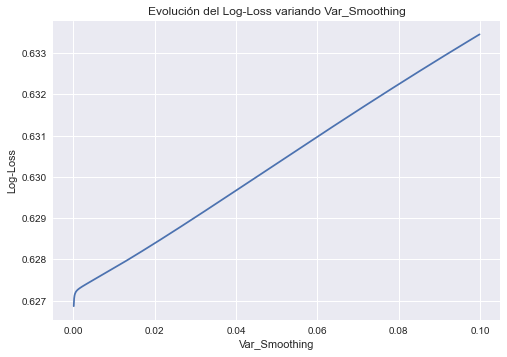

In [121]:
from matplotlib import style
plt.plot(res_var.param_var_smoothing.values,res_var.mean_test_score.values)
plt.title("Evolución del Log-Loss variando Var_Smoothing")
plt.xlabel("Var_Smoothing")
plt.ylabel("Log-Loss")
style.use("seaborn")
plt.show()

In [115]:
res_priors = res.loc[res["param_var_smoothing"] == 0.0001]

In [116]:
res_priors["param_priors_"] = res_priors["param_priors"].transform(lambda x : x[0])

<ipython-input-116-278efb5a23e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_priors["param_priors_"] = res_priors["param_priors"].transform(lambda x : x[0])


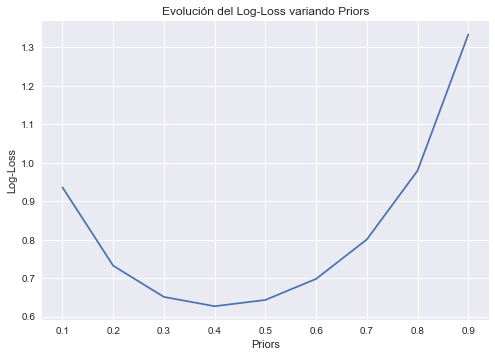

In [123]:
res_priors = res_priors.loc[res_priors.param_priors_ >= 0.1]
plt.plot(res_priors.param_priors_.values,res_priors.mean_test_score.values)
plt.title("Evolución del Log-Loss variando Priors")
plt.xlabel("Priors")
plt.ylabel("Log-Loss")
plt.show()